## **Trend Analysis**

We would use two basic packages below,

**Guidelines:**

- **yahoo finance api** : https://github.com/ranaroussi/yfinance

- **Candlestick chart** : https://github.com/matplotlib/mplfinance

In [1]:
import warnings
import winsound
warnings.simplefilter("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
from pandas_datareader import data as pdr
import numpy as np
from scipy import signal #滤波等
import datetime

yf.pdr_override()

In [4]:
def get_data(stock_code):
    data=pdr.get_data_yahoo(tickers=stock_code,
                            interval='1d',
                            start='2012-06-01',
                            end='2020-11-13')
    return data
# An example, this api could take a little while to fetch the data
# JUST BE PATIENT
data=get_data('AAPL')
data.head()    

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-31,20.740715,20.767857,20.409286,20.633215,17.654713,491674400
2012-06-01,20.327143,20.451786,20.018572,20.035357,17.143160,520987600
2012-06-04,20.053572,20.267857,19.589285,20.153214,17.244005,556995600
2012-06-05,20.045357,20.231071,19.940357,20.101072,17.199389,388214400
2012-06-06,20.277500,20.494642,20.196428,20.409286,17.463108,401455600


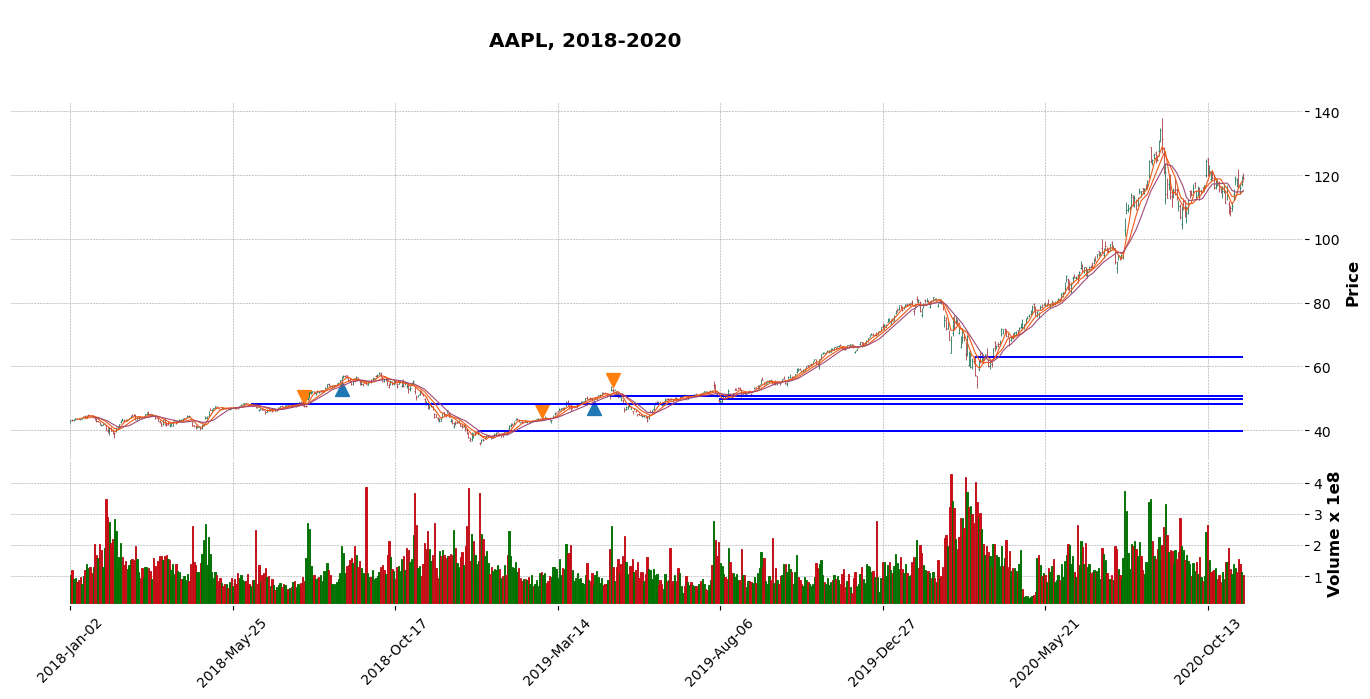

In [3]:
# import numpy as np
# data1=data.loc['2018-01-01':'2020-11-12']
# #first we can find the critical points from some calculation
# #There are 5 randomly choosen points
# points=['2018-06-12','2019-01-02','2019-04-30','2019-08-05','2020-03-20']
# seq_of_points=[
#     [(i,data.loc[i,'High']),('2020-11-12',data.loc[i,'High'])] for i in points
# ] 
# # or Lowest found, just change the argument 'High' to 'Low'
# # 两点确定一条直线
# # suppose we have 3 critical upward break points and 2 downward break points represents high or low signal
# points_break_up = ['2018-07-30','2019-02-28','2019-05-02'] #randomly choosen
# points_break_down = ['2018-08-30','2019-04-15']
# high_signal=[]
# low_signal=[]
# for i in [str(data1.index[j])[0:10] for j in range(len(data1))]:    
#     if i in points_break_up:
#         high_signal.append(data1.loc[i,'High']*1.05)
#     else: high_signal.append(np.nan)
#     if i in points_break_down:
#         low_signal.append(data1.loc[i,'Low']*0.95)
#     else: low_signal.append(np.nan)
# apds = [ 
#          mpf.make_addplot(low_signal,type='scatter',markersize=100,marker='^'),
#          mpf.make_addplot(high_signal,type='scatter',markersize=100,marker='v')
#        ]
# mpf.plot(data1,style='charles',title='\nAAPL, 2018-2020',mav=(5,10,15),figratio=(25,10),figscale=1.25,
#         alines=dict(alines=seq_of_points,colors=['b' for i in range(len(seq_of_points))],linewidths=0.2),
#         addplot=apds,volume=True) 

In [ ]:
#mpf.plot(data1,style='charles',title='\nAAPL, 2018-2020',mav=(5,10,15),figratio=(25,10),figscale=1.25,
#        alines=dict(alines=seq_of_points,colors=['b' for i in range(len(seq_of_points))],linewidths=0.2),
#        addplot=apds,volume=True,savefig='AAPL_candle_line.jpg') 

# if needed, figure could be saved with codes above↑

### 多项式拟合平滑曲线效果展示

- 使用$k$阶多项式拟合股价曲线，其中$k$可以自行设置

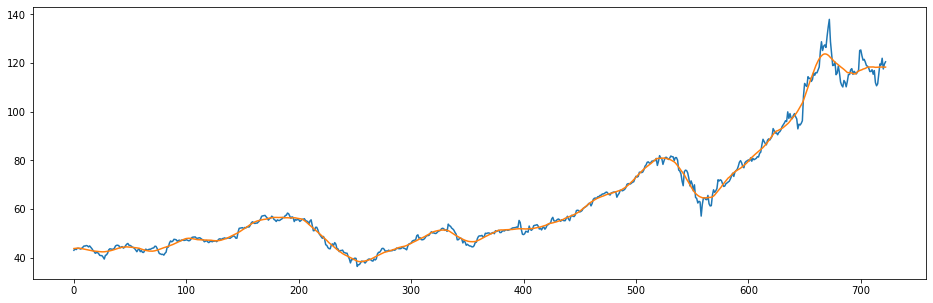

In [7]:
from scipy.signal import savgol_filter
data1=data.loc['2018-01-01':'2020-11-12']
plt.figure(figsize=(16,5))
plt.plot(np.array(data1['High']))
plt.plot(savgol_filter(data1['High'], 49, 3, mode= 'nearest') )

### 寻找波峰波谷

- 参数：
    - distance: 相邻峰之间的最小水平距离, 先移除较小的峰，直到所有剩余峰的条件都满足为止。
    - prominence: 突起程度
    - width: 波峰的宽度
    - height: 低于指定height的信号都不考虑，此处没有用到该参数
    - threshold: 其与相邻样本的垂直距离，此处没有用到该参数
    - plateau_size: 保证峰对应的平顶数目大于给定值，此处没有用到该参数

In [9]:
def find_peaks_troughs(data,window_length,k,distance, prominence,width,mode='peaks'):
    if mode=='peaks':
        smoothed_data=savgol_filter(data, window_length, k, mode= 'nearest') 
    if mode=='troughs':
        smoothed_data=savgol_filter(-data, window_length, k, mode= 'nearest') 
    pk_indexes = signal.find_peaks(smoothed_data, distance=distance, prominence=prominence,width=width)[0] #distance表极大值点的距离至少大于等于10个水平单位 
    points=[]
    for i in pk_indexes:
        points.append((i,data[i]))
    return points


### 合并相近点

- step1: 生成重要点的集合$S_0$，这些点是一维空间中的点
- step2: 对$S_0$中的点划分子集（划分聚落），设定阈值$m$，子集内两点最大距离为$m$，生成$n$个子集$s_1, s_2, s_3...s_n \in S_0 $，有的子集内只有一个点，有的子集内有多个点，他们是相近的点
- step3: 对于每个子集，以该子集内点的均值点代替该子集，生成新的重要点的集合$S_1$
- 重复step2、step3，直至$S_{n-1}=S_n$
- 结果会给出$S_n$中每个点代表原始$S_0$的几个点

In [115]:
# # 带日期、看集中区域点的数量
# def merge_close_point(l,k):
#     unadjusted_points=l.sort_values(by=l.columns[0])
#     adjusted_points=[]#需要被调整的集合
#     close_points=pd.DataFrame() #需要被调整的集合内的点
#     for i in range(len(unadjusted_points)-1):
#         n=0
#         for j in range(i+1,len(unadjusted_points)):
#             if unadjusted_points.iloc[j,0]-unadjusted_points.iloc[i,0]<k:
#                 close_points=close_points.append(unadjusted_points.iloc[[i]],ignore_index=False)
#                 close_points=close_points.append(unadjusted_points.iloc[[j]],ignore_index=False)
#                 if n==0:
#                     adjusted_points.append(pd.DataFrame())
#                     adjusted_points[-1]=adjusted_points[-1].append(unadjusted_points.iloc[[i]],ignore_index=False)
#                 adjusted_points[-1]=adjusted_points[-1].append(unadjusted_points.iloc[[j]],ignore_index=False)
#                 n+=1  
# #     adjusted_points删除子集
#     for i in range(len(adjusted_points)-1):
#         for j in range(i+1,len(adjusted_points)):
#             try:
#                 if set(adjusted_points[j].iloc[:,0])<set(adjusted_points[i].iloc[:,0]):
#                     adjusted_points.remove(adjusted_points[j])
#                 if set(adjusted_points[i].iloc[:,0])<set(adjusted_points[j].iloc[:,0]):
#                     adjusted_points.remove(adjusted_points[i])
#             except:
#                 pass
    
#     unadjusted_points = unadjusted_points.append(close_points)
#     unadjusted_points = unadjusted_points.append(close_points)
#     new_points = unadjusted_points.drop_duplicates(keep=False)
    
#     for i in adjusted_points:
#         i=i.sort_index()
#         new_points.loc[i.index[0]]=[i.iloc[:,0].mean(),i.iloc[:,1].sum()]
#     return new_points

# def iterate_merge(l,k):
#     record=[l,merge_close_point(l,k)]
#     while len(record[-1])!=len(record[-2]):
#         record.append(merge_close_point(record[-1],k))
#     return record[-1]

In [34]:
# 带日期、集中区域点的数量、标准差
def merge_close_point(l,k,n_std):
    unadjusted_points=l.sort_values(by=l.columns[0])
    adjusted_points=[]#需要被调整的集合
    close_points=pd.DataFrame() #需要被调整的集合内的点
    for i in range(len(unadjusted_points)-1):
        n=0
        for j in range(i+1,len(unadjusted_points)):
            if unadjusted_points.iloc[j,0]-unadjusted_points.iloc[i,0]<k:
                close_points=close_points.append(unadjusted_points.iloc[[i]],ignore_index=False)
                close_points=close_points.append(unadjusted_points.iloc[[j]],ignore_index=False)
                if n==0:
                    adjusted_points.append(pd.DataFrame())
                    adjusted_points[-1]=adjusted_points[-1].append(unadjusted_points.iloc[[i]],ignore_index=False)
                adjusted_points[-1]=adjusted_points[-1].append(unadjusted_points.iloc[[j]],ignore_index=False)
                n+=1  
#     adjusted_points删除子集
    for i in range(len(adjusted_points)-1):
        for j in range(i+1,len(adjusted_points)):
            try:
                if set(adjusted_points[j].iloc[:,0])<set(adjusted_points[i].iloc[:,0]):
                    adjusted_points.remove(adjusted_points[j])
                if set(adjusted_points[i].iloc[:,0])<set(adjusted_points[j].iloc[:,0]):
                    adjusted_points.remove(adjusted_points[i])
            except:
                pass
    
    unadjusted_points = unadjusted_points.append(close_points)
    unadjusted_points = unadjusted_points.append(close_points)
    new_points = unadjusted_points.drop_duplicates(keep=False)
    
    for i in adjusted_points:
        std=i.iloc[:,0].std()
        mean=i.iloc[:,0].mean()
        condition=((i[i.columns[0]]<mean+n_std*std)&(i[i.columns[0]]>mean-n_std*std))
        j=i[condition]
        k=i[~condition]
        j=j.sort_index()
        if len(j)>0:
            new_points=pd.concat([new_points,k],axis=0)
        new_points.loc[j.index[0]]=[j.iloc[:,0].mean(),j.iloc[:,1].sum()]
    new_points = new_points.drop_duplicates(keep="first")
    
    return new_points

def iterate_merge(l,k,n_std):
    record=[l,merge_close_point(l,k,n_std)]
    while len(record[-1])!=len(record[-2]):
#         print(1)
        record.append(merge_close_point(record[-1],k,n_std))
    return record[-1]

#### 样例

In [43]:
start='2012-06-01'
end='2020-10-20'
data1=data.loc[start:end]
peak_day=[]
troughs_day=[]
window_length=49
k=3 #3阶多项式拟合
distance=120
prominence=1.5
width=3

smoothed_high=savgol_filter(data1['High'], window_length, k, mode= 'nearest') 
smoothed_low=savgol_filter(data1['Low'], window_length, k, mode= 'nearest') 

for i in find_peaks_troughs(data1['High'],window_length,k,distance, prominence,width):
    peak_day.append(str(data1.index[i[0]])[:10])
for i in find_peaks_troughs(data1['Low'],window_length,k,distance, prominence,width,mode='troughs'):
    troughs_day.append(str(data1.index[i[0]])[:10])
    
df1=pd.DataFrame(data1.loc[:,'High'][peak_day])
df1['n']=1
iterate_merge(df1,3,n_std=2).index[1]+datetime.timedelta(days=365)


Timestamp('2016-11-16 00:00:00')

In [36]:
data1.loc[:,'High'][peak_day]

Date
2012-09-12     23.924999
2015-05-19     32.720001
2015-11-17     28.762501
2016-10-12     29.495001
2017-08-28     40.500000
2018-03-12     45.597500
2018-09-26     55.937500
2020-02-03     78.372498
2020-08-27    127.485001
Name: High, dtype: float64

### 画图

In [78]:
#新
def draw_lines(stock,start,end,window_length,k,distance, prominence,width,merge_range,n,n_std):
    data=get_data(stock)
    data1=data.loc[start:end]
    peak_day=[]
    troughs_day=[]
    peak=[]
    troughs=[]
    for i in find_peaks_troughs(data1['High'],window_length,k,distance, prominence,width):
        peak_day.append(str(data1.index[i[0]])[:10])
    for i in find_peaks_troughs(data1['Low'],window_length,k,distance, prominence,width,mode='troughs'):
        troughs_day.append(str(data1.index[i[0]])[:10])
        
    df1=pd.DataFrame(data1.loc[:,'High'][peak_day])
    df1['n']=1
    merged_points1=iterate_merge(df1,merge_range,n_std)
    merged_points1=merged_points1[merged_points1['n']>=n]
    
    df2=pd.DataFrame(data1.loc[:,'Low'][troughs_day])
    df2['n']=1
    merged_points2=iterate_merge(df2,merge_range,n_std)
    merged_points2=merged_points2[merged_points2['n']>=n]
#     merged_points1=iterate_merge(data1.loc[:,'Low'][troughs_day],merge_range)
#     merged_points2=iterate_merge(data1.loc[:,'High'][peak_day],merge_range)    
    seq_of_points1=[
         [(str(merged_points1.iloc[i,:].name)[:10],merged_points1.iloc[i,0]),
          (str(min(max(data1.index),merged_points1.iloc[i,:].name+datetime.timedelta(days=3*365)))[:10],merged_points1.iloc[i,0])] 
        for i in range(len(merged_points1))
    ]
    seq_of_points2=[
         [(str(merged_points2.iloc[i,:].name)[:10],merged_points2.iloc[i,0]),
          (str(min(max(data1.index),merged_points2.iloc[i,:].name+datetime.timedelta(days=3*365)))[:10],merged_points2.iloc[i,0])] 
        
        for i in range(len(merged_points2))
    ]
    seq_of_points=seq_of_points1+seq_of_points2
    

    for i in [str(data1.index[j])[0:10] for j in range(len(data1))]:    
        if i in peak_day:
            peak.append(data1.loc[i,'High']*1.1)
        else: peak.append(np.nan)
        if i in troughs_day:
            troughs.append(data1.loc[i,'Low']*0.9)
        else: troughs.append(np.nan)

    apds = [ 
             mpf.make_addplot(troughs,type='scatter',markersize=100,marker='^'),
             mpf.make_addplot(peak,type='scatter',markersize=100,marker='v')
           ]
    mpf.plot(data1,style='charles',title='\n%s'%stock,mav=(5,10,15),figratio=(25,10),figscale=1.25,
            alines=dict(alines=seq_of_points,colors=['b' for i in range(len(seq_of_points))],linewidths=0.2),
            addplot=apds,volume=True) 
    return merged_points2,merged_points1


### 参数总结

- 参数：
    - window_length：拟合窗口
    - k：k阶多项式拟合
    - distance: 相邻峰之间的最小水平距离, 先移除较小的峰，直到所有剩余峰的条件都满足为止。
    - prominence: 突起程度
    - width: 波峰的宽度
    - merge_range：近似点之间最大距离
    - n：同一条水平线上最少有几个重要点才会被显示
    - n_std：几个标准差内的点会被聚合

## 检验

In [91]:
def test(stock,start,end,window_length,k,distance, prominence,width,merge_range,n,n_std):
    data=get_data(stock)
    data1=data.loc[start:end]
    peak_day=[]
    troughs_day=[]
    peak=[]
    troughs=[]
    for i in find_peaks_troughs(data1['High'],window_length,k,distance, prominence,width):
        peak_day.append(str(data1.index[i[0]])[:10])
    for i in find_peaks_troughs(data1['Low'],window_length,k,distance, prominence,width,mode='troughs'):
        troughs_day.append(str(data1.index[i[0]])[:10])
        
    df1=pd.DataFrame(data1.loc[:,'High'][peak_day])
    df1['n']=1
    merged_points1=iterate_merge(df1,merge_range,n_std)
    merged_points1=merged_points1[merged_points1['n']>=n]
    j=0
    i=merged_points1.index[j]
    line=merged_points1.iloc[j,0]
    df=data1[data1.index>=i]
    return df.head(10),line


In [92]:
a=test('AAPL',start='2012-06-01',end='2020-10-20',window_length=49,k=3,
           distance=120,prominence=2,width=3,merge_range=3,n=1,n_std=2)
a

[*********************100%***********************]  1 of 1 completed


(                 Open       High        Low      Close  Adj Close     Volume
 Date                                                                        
 2012-09-12  23.816071  23.924999  23.428572  23.921072  20.555832  712233200
 2012-09-13  24.191786  24.482143  24.098928  24.392143  20.960629  598360000
 2012-09-14  24.641428  24.892143  24.567499  24.688572  21.215359  600474000
 2012-09-17  24.976786  24.992857  24.807501  24.992144  21.476221  398031200
 2012-09-18  24.995714  25.083214  24.872143  25.068214  21.541594  373503200
 2012-09-19  25.009285  25.142500  24.984642  25.075001  21.547426  326874800
 2012-09-20  24.969999  25.002142  24.772142  24.953571  21.443083  336568400
 2012-09-21  25.086071  25.181072  24.977142  25.003214  21.485735  571589200
 2012-09-24  24.530714  24.825714  24.392857  24.671072  21.200321  639766400
 2012-09-25  24.580715  24.742144  24.035715  24.055000  20.670914  518789600,
 23.924999237060547)

## AAPL

[*********************100%***********************]  1 of 1 completed


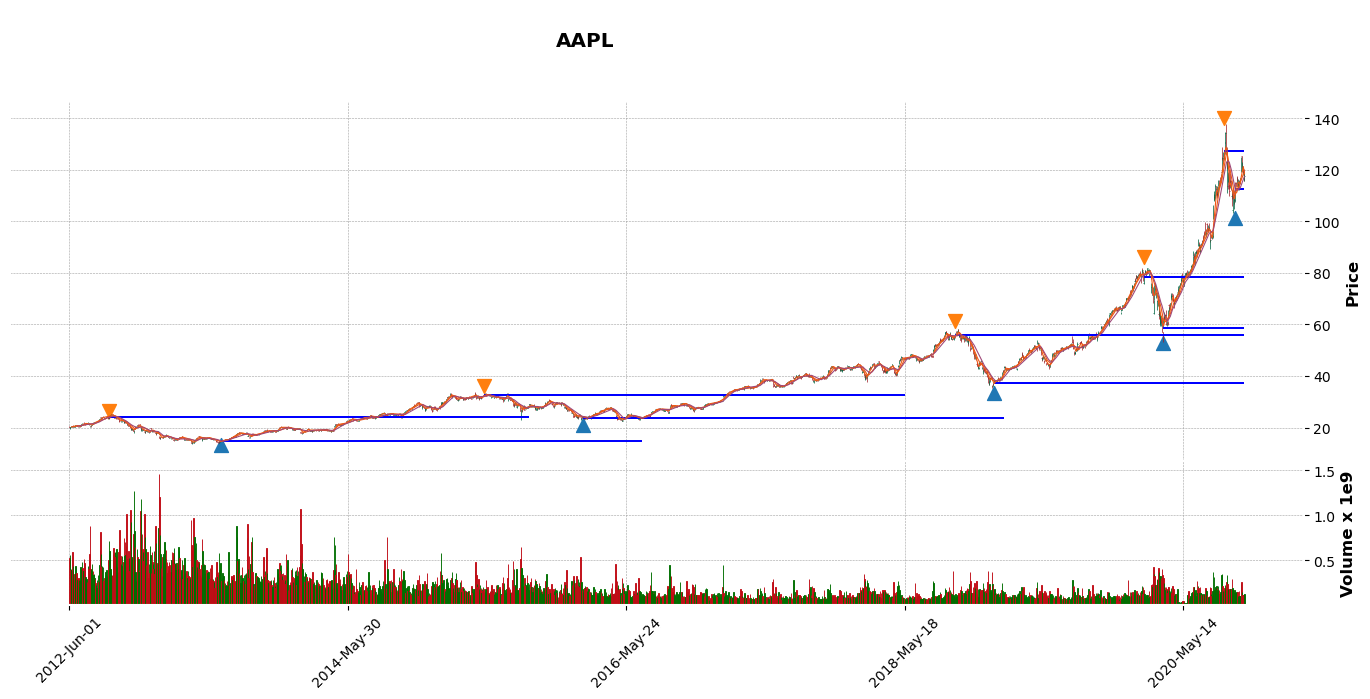

(                   Low  n
 Date                     
 2013-07-03   14.908929  1
 2016-02-03   23.520000  1
 2019-01-08   37.130001  1
 2020-03-24   58.575001  1
 2020-09-28  112.779999  1,
                   High  n
 Date                     
 2012-09-12   23.924999  1
 2015-05-19   32.720001  1
 2018-09-26   55.937500  1
 2020-02-03   78.372498  1
 2020-08-27  127.485001  1)

In [56]:
draw_lines('AAPL',start='2012-06-01',end='2020-10-20',window_length=49,k=3,
           distance=120,prominence=2,width=3,merge_range=3,n=1,n_std=2)

## MSFT

[*********************100%***********************]  1 of 1 completed


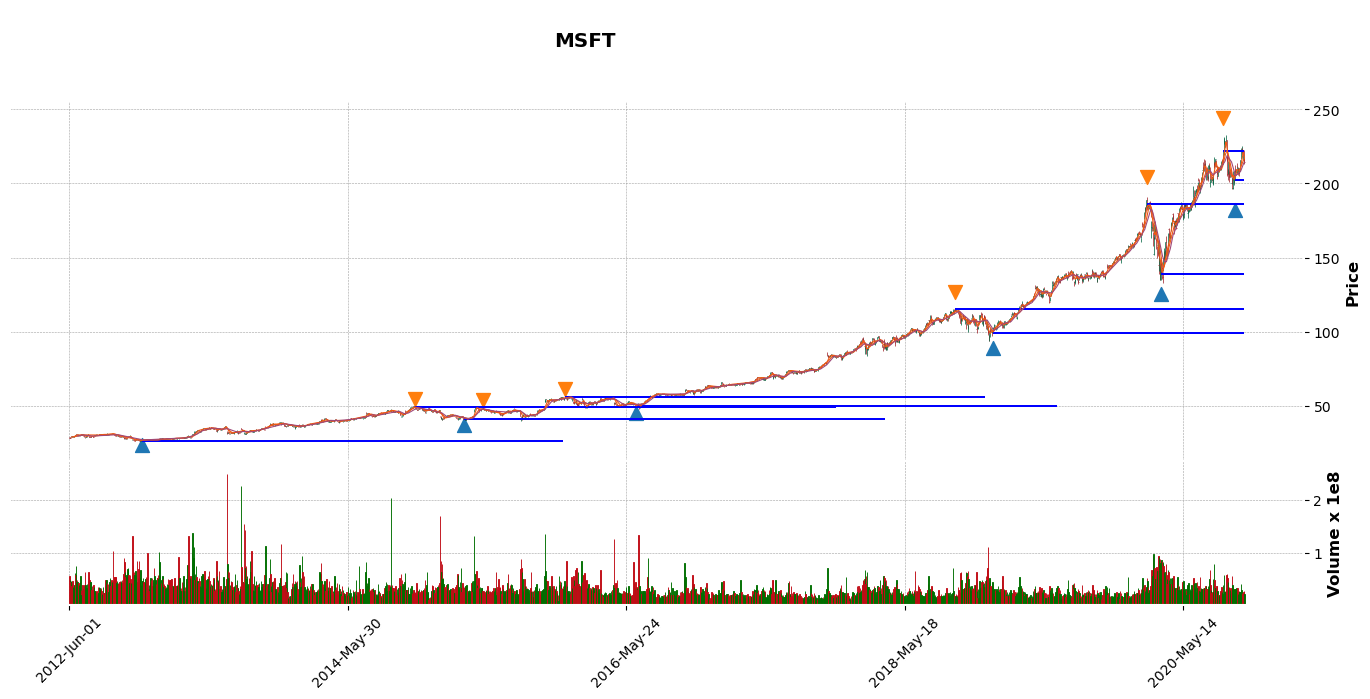

(                   Low  n
 Date                     
 2012-12-10   26.520000  1
 2015-03-30   40.910000  1
 2016-06-20   50.029999  1
 2019-01-04   98.930000  1
 2020-03-19  139.000000  1
 2020-09-25  202.539993  1,
                   High    n
 Date                       
 2014-11-18   49.120001  2.0
 2015-12-15   55.900002  1.0
 2018-09-26  115.059998  1.0
 2020-02-12  185.850006  1.0
 2020-08-26  222.089996  1.0)

In [93]:
draw_lines('MSFT',start='2012-06-01',end='2020-10-20',window_length=49,k=3,
           distance=120,prominence=3,width=3,merge_range=3,n=1,n_std=2)

## Amzn

[*********************100%***********************]  1 of 1 completed


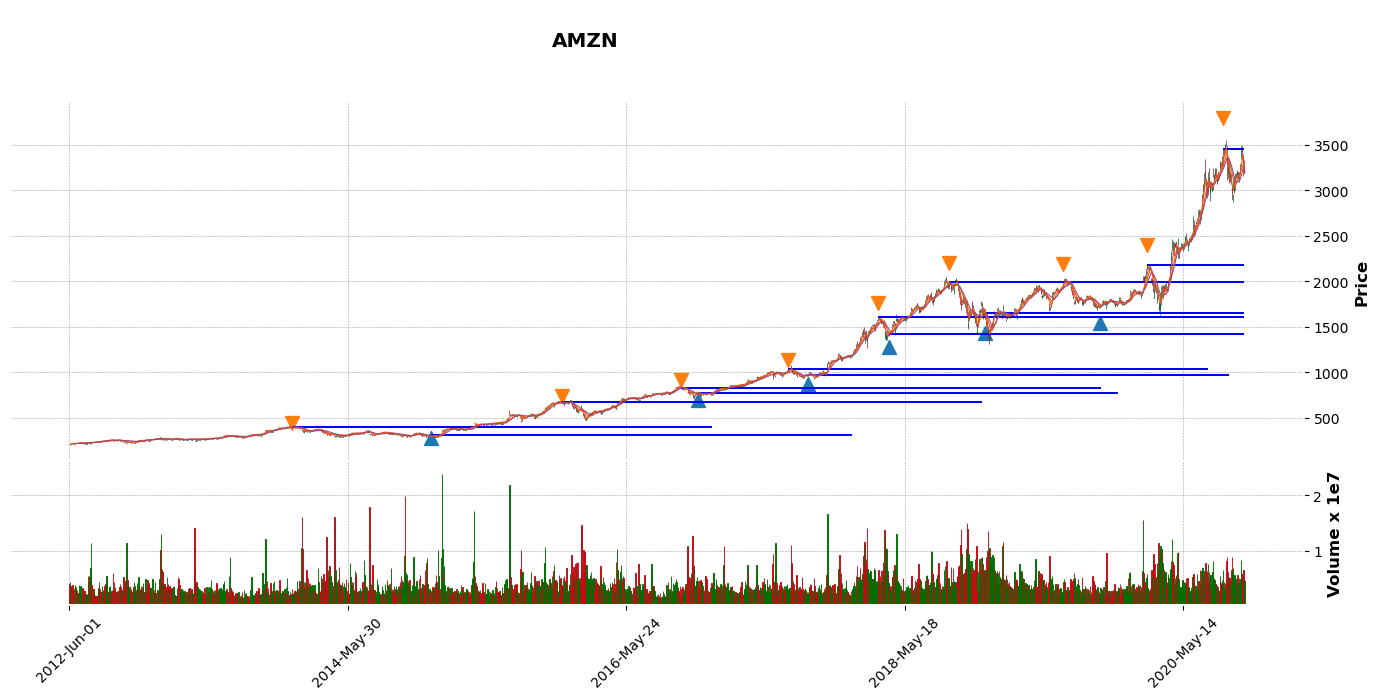

(                    Low    n
 Date                        
 2015-01-02   306.959991  1.0
 2016-11-25   777.900024  1.0
 2017-09-11   974.219971  1.0
 2018-04-10  1415.699951  1.0
 2018-12-14  1649.679993  2.0,
                    High    n
 Date                        
 2014-01-03   402.709991  1.0
 2015-12-07   675.460022  1.0
 2016-10-13   831.799988  1.0
 2017-07-20  1034.969971  1.0
 2018-03-12  1605.329956  1.0
 2018-09-12  1995.005005  2.0
 2020-02-12  2180.250000  1.0
 2020-08-26  3451.739990  1.0)

In [100]:
draw_lines('AMZN',start='2012-06-01',end='2020-10-20',window_length=49,k=3,
           distance=120,prominence=40,width=3,merge_range=150,n=1,n_std=2)

## Fb

[*********************100%***********************]  1 of 1 completed


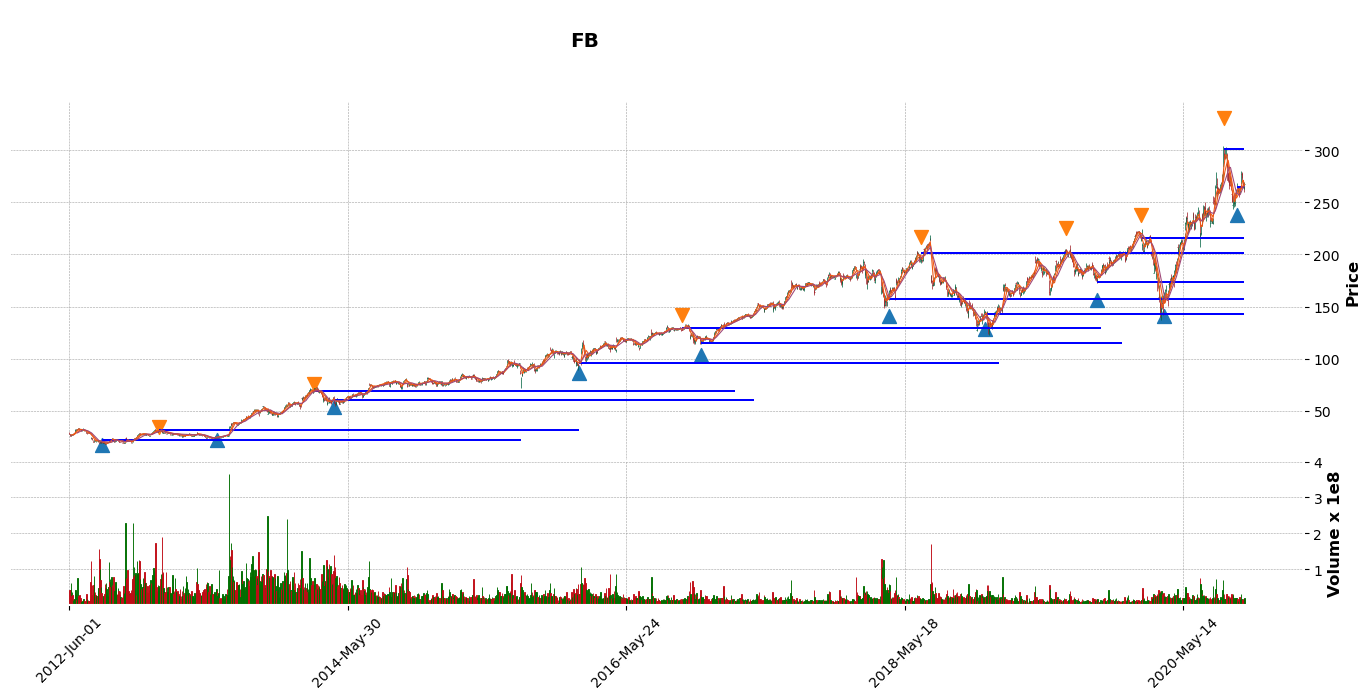

(                   Low    n
 Date                       
 2012-08-23   21.700001  2.0
 2014-04-24   59.770000  1.0
 2016-01-22   95.489998  1.0
 2016-12-05  115.070000  1.0
 2018-12-13  143.190002  1.0
 2018-04-10  157.014999  2.0
 2019-10-03  173.630005  1.0
 2020-10-01  264.799988  1.0,
                   High    n
 Date                       
 2013-01-24   31.490000  1.0
 2014-03-04   68.900002  1.0
 2016-10-14  128.949997  1.0
 2018-07-02  201.389999  2.0
 2020-01-27  216.059998  1.0
 2020-08-27  301.230011  1.0)

In [95]:
draw_lines('FB',start='2012-06-01',end='2020-10-20',window_length=49,k=3,
           distance=120,prominence=5,width=3,merge_range=10,n=1,n_std=2)

## Googl

[*********************100%***********************]  1 of 1 completed


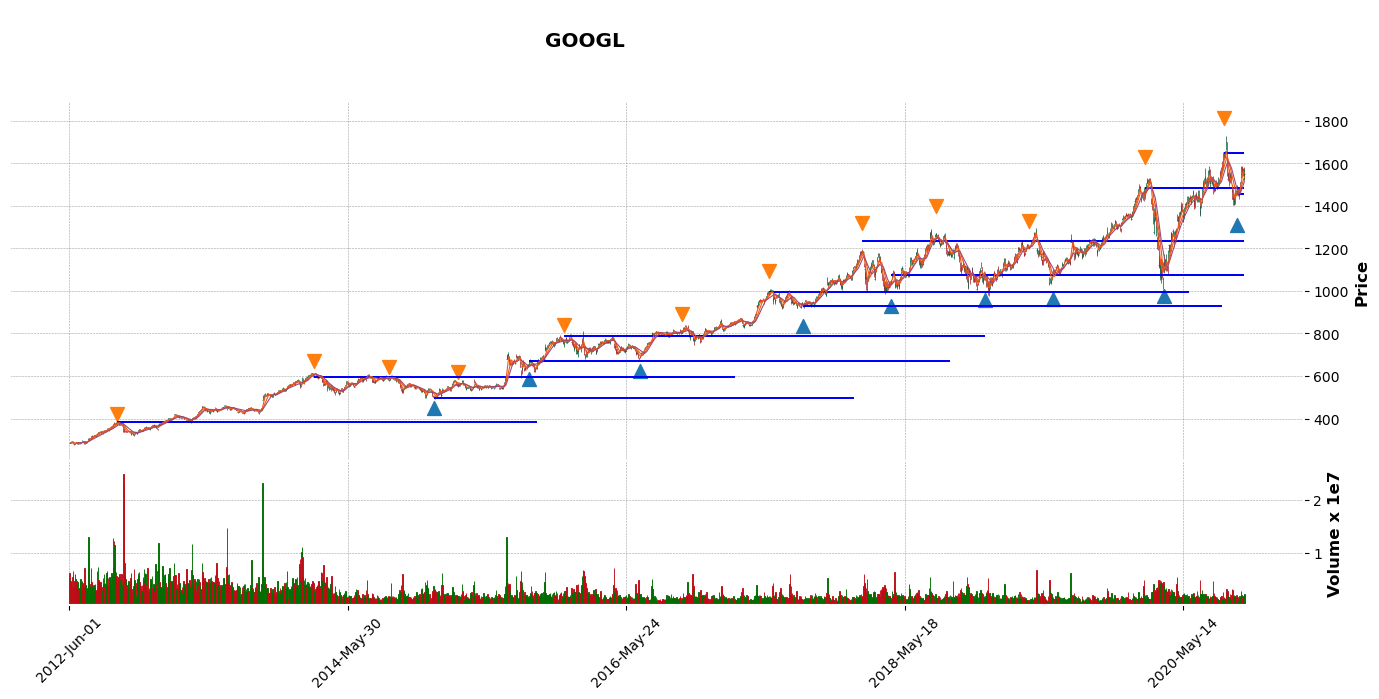

(                    Low     n
 Date                         
 2015-01-09   498.649994   1.0
 2015-09-15   673.010010   2.0
 2017-08-25   930.099976   1.0
 2018-04-13  1072.338882  14.0
 2020-09-30  1455.760010   1.0,
                    High    n
 Date                        
 2012-10-02   383.378387  1.0
 2014-03-04   596.264282  2.0
 2015-12-14   787.120026  2.0
 2017-06-01   993.140015  1.0
 2018-01-29  1233.274963  5.0
 2020-02-06  1481.560059  1.0
 2020-08-27  1647.989990  1.0)

In [96]:
draw_lines('GOOGL',start='2012-06-01',end='2020-10-20',window_length=49,k=3,
           distance=120,prominence=20,width=3,merge_range=100,n=1,n_std=2)

## TSLA

[*********************100%***********************]  1 of 1 completed


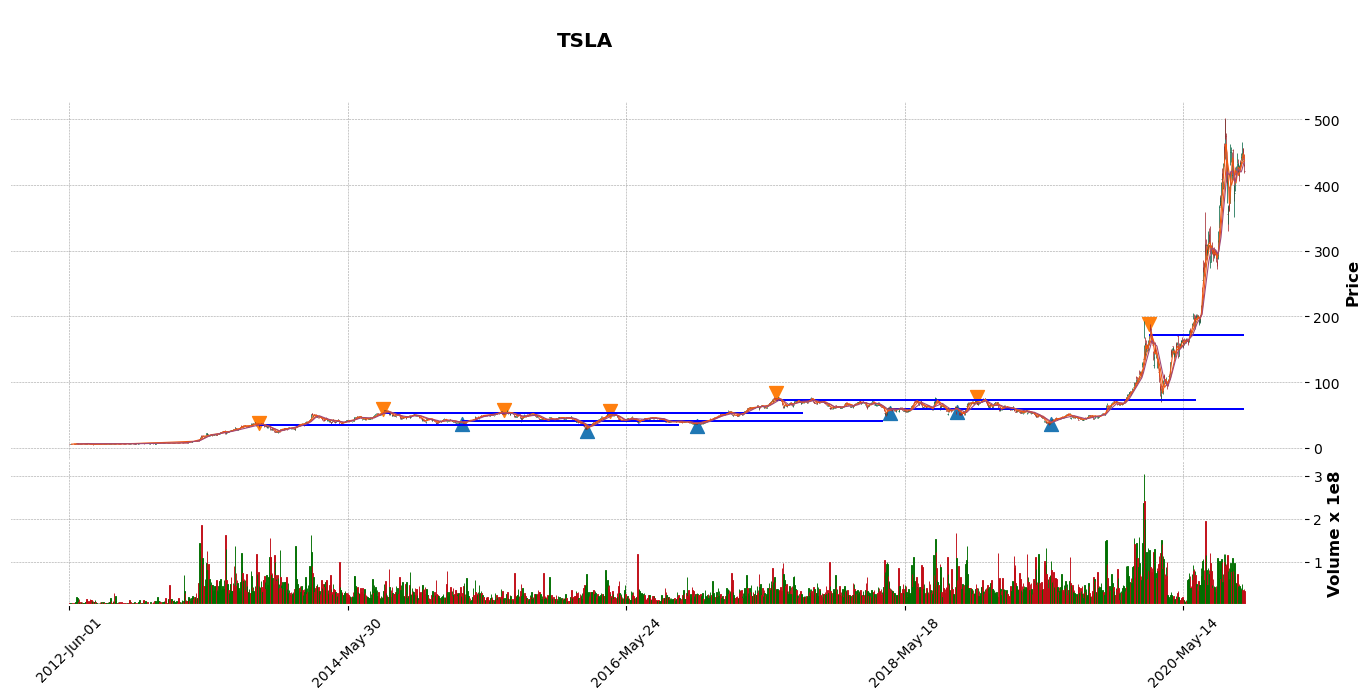

(                  Low    n
 Date                      
 2015-03-24  40.155001  2.0
 2018-04-12  59.283001  2.0,
                   High    n
 Date                       
 2013-10-09   34.998001  1.0
 2014-08-29   53.500000  2.0
 2017-06-19   72.980000  2.0
 2020-02-18  172.000000  1.0)

In [97]:
draw_lines('TSLA',start='2012-06-01',end='2020-10-20',window_length=49,k=3,
           distance=120,prominence=10,width=3,merge_range=16,n=1,n_std=2)